# Maintenance Project

In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
print("Setup Complete")

Setup Complete


In [2]:
df = pd.read_csv("data/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Data Cleaning

In [3]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

There does not seem to be any missing values

In [4]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [5]:
dv = df.drop(['UDI', 'Product ID'], axis=1)
feature_columns = ['quality', 'air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear']
target_columns = ['machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
dv.columns = feature_columns + target_columns

dv['quality'], quality_cat = dv['quality'].factorize()
cat_columns = ['quality', 'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
num_columns = ['air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear']

dv.head()

,quality,air_temp,process_temp,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
dv.dtypes

quality               int64
air_temp            float64
process_temp        float64
rotational_speed      int64
torque              float64
tool_wear             int64
machine_failure       int64
twf                   int64
hdf                   int64
pwf                   int64
osf                   int64
rnf                   int64
dtype: object

## Data Visualization

<AxesSubplot:xlabel='process_temp', ylabel='Count'>

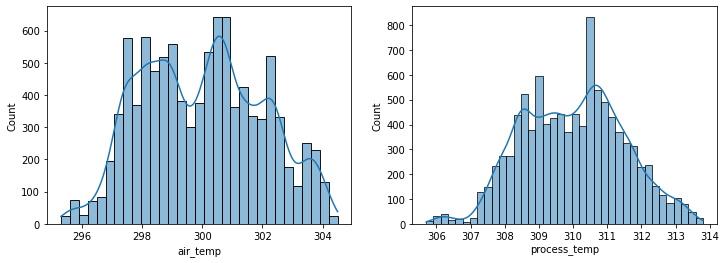

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data=dv, x='air_temp', kde=True, ax=ax[0])
sns.histplot(data=dv, x='process_temp', kde=True, ax=ax[1])

<AxesSubplot:xlabel='quality', ylabel='tool_wear'>

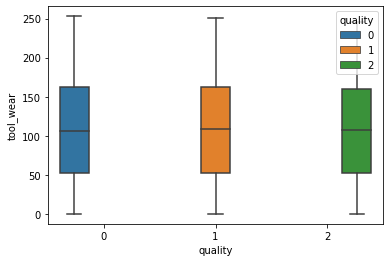

In [16]:
sns.boxplot(data=dv, x='quality', y='tool_wear', hue='quality')

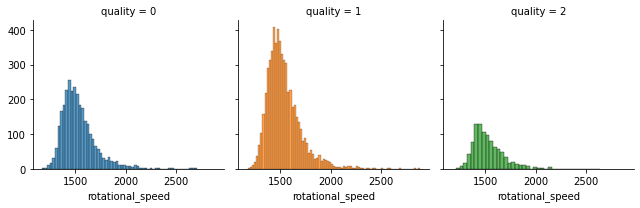

In [17]:
graph = sns.FacetGrid(data=dv, 
                      col='quality', 
                      hue='quality', )
graph.map(sns.histplot, 'rotational_speed')

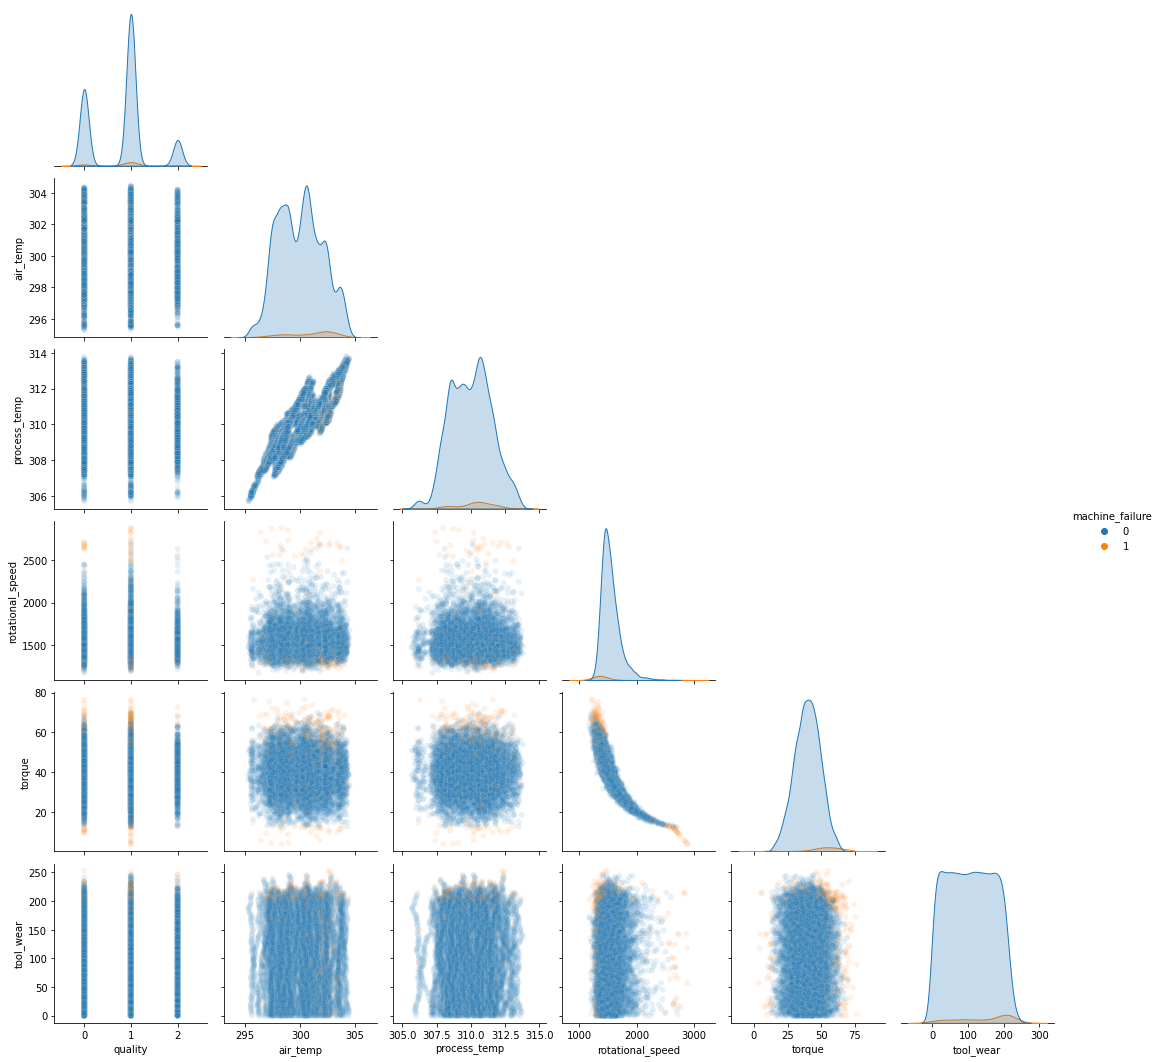

In [18]:
sns.pairplot(dv[feature_columns+['machine_failure']], hue='machine_failure', plot_kws={'alpha':0.1}, corner=True)

There seems to be linear relationship between `air_temp` and `process_temp`. Furthermore, `rotational_speed` and `torque` are likely to be inversely related.

It is also interesting to note that the distributions of `air_temp` and `process_temp` are bimodal 

<AxesSubplot:>

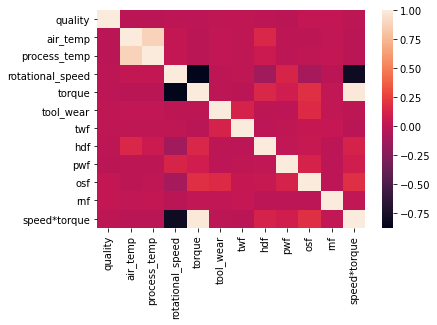

In [19]:
dv['speed*torque'] = dv['rotational_speed'] * dv['torque']
dv_corr = dv.corr()
sns.heatmap(dv_corr)

Quality does not seem to correlate and influence any other feature and target, so it is probably easier if we just drop it

<AxesSubplot:xlabel='speed*torque', ylabel='air_temp'>

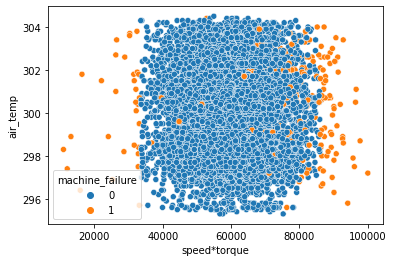

In [27]:
sns.scatterplot(data=dv, x='speed*torque', y='air_temp', hue='machine_failure')

In [ ]:
dv['torque2'] = dv['torque'] * dv['torque']
dv['speed2'] = dv['speed'] * dv['speed']

## Machine Learning
### Random Forest Classifier

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

maintenance = df.drop(['UDI', 'Product ID'], axis=1)
feature_columns = ['quality', 'air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear']
target_columns = ['machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
maintenance.columns = feature_columns + target_columns

X = maintenance[feature_columns]
y = maintenance['machine_failure']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=42, 
                                                      test_size=0.2)

standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder()
simple_imputer = SimpleImputer(strategy='median')
poly_features = PolynomialFeatures(degree=2) # 2nd-degree polynomial

Add `speed_times_torque` as a new feature

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin
rotational_speed, torque = 3, 4
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return;
    def fit(self, X, y=None):
        return self;
    def transform(self, X, y=None):
        #speed_times_torque = X[:,rotational_speed] * X[:,torque]
        #return np.c_[X, speed_times_torque];
        inv_speed = np.ones(shape=X.shape[0]) / X[:,rotational_speed]
        inv_torque = np.ones(shape=X.shape[0]) / X[:,torque]
        return np.c_[X, inv_speed, inv_torque];
        
    
attribs_adder = CombinedAttributesAdder()

In [70]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('simple_imputer', simple_imputer),
    
    ('poly_features', poly_features),
    ('attribs_adder', attribs_adder),
    ('std_scaler', standard_scaler)
])

cat_pipeline = Pipeline([
    ('ordinal_encoder', ordinal_encoder)
])

In [71]:
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, ['quality'])
])

In [72]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(random_state=42)

In [73]:
full_pipeline = Pipeline([
    ('preprocess_pipeline', preprocess_pipeline),
    ('model', rfc_model)
])

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly_features',
                                                                   PolynomialFeatures()),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['air_temp', 'process_temp',
                                                   'rotational_speed', 'torque',
                                                   'tool_wear']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['quality'])])),
                ('model', RandomForestClassifier(random_state=42))])

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier (Validation)')

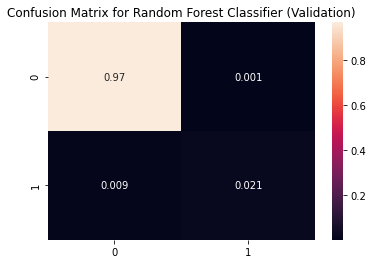

In [102]:
from sklearn.metrics import confusion_matrix
y_valid_pred = full_pipeline.predict(X_valid)

plt.figure()
sns.heatmap(confusion_matrix(y_valid, y_valid_pred)/y_valid.shape[0], annot=True, annot_kws={'size':10})
plt.title('Confusion Matrix for Random Forest Classifier (Validation)')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier (Training)')

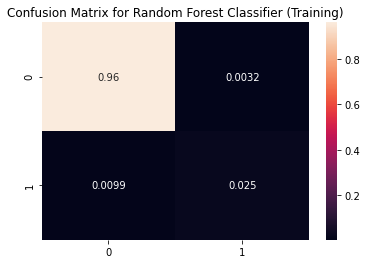

In [101]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(full_pipeline, X_train, y_train, cv=5)

plt.figure()
sns.heatmap(confusion_matrix(y_train, y_train_pred)/y_train.shape[0], annot=True, annot_kws={'size':10})
plt.title('Confusion Matrix for Random Forest Classifier (Training)')

In [94]:
from sklearn.metrics import precision_score, recall_score
print('Training Recall Score: ', recall_score(y_train, y_train_pred))
print('Training Precision Score: ', precision_score(y_train, y_train_pred))
print('Validation Recall Score: ', recall_score(y_valid, y_valid_pred))
print('Validation Precision Score: ', precision_score(y_valid, y_valid_pred))

Training Recall Score:  0.7158273381294964
Training Precision Score:  0.8844444444444445
Validation Recall Score:  0.7049180327868853
Validation Precision Score:  0.9555555555555556


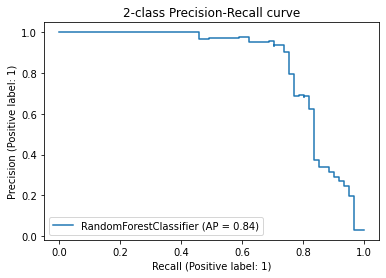

In [92]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    full_pipeline, X_valid, y_valid, name="RandomForestClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Support Vector Machines (SVM) Classifier

In [107]:
from sklearn.svm import LinearSVC

svc_model = LinearSVC()

full_pipeline = Pipeline([
    ('preprocess_pipeline', preprocess_pipeline),
    ('model', svc_model)
])

full_pipeline.fit(X_train, y_train)

C:\Users\Claudeon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly_features',
                                                                   PolynomialFeatures()),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['air_temp', 'process_temp',
                                                   'rotational_speed', 'torque',
                                                   'tool_wear']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['quality'])])),
                ('model', LinearSVC())])

Text(0.5, 1.0, 'Confusion Matrix for LinearSVC (Validation)')

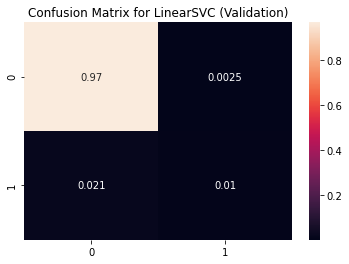

In [114]:
from sklearn.metrics import confusion_matrix
y_valid_pred = full_pipeline.predict(X_valid)

plt.figure()
sns.heatmap(confusion_matrix(y_valid, y_valid_pred)/y_valid.shape[0], annot=True, annot_kws={'size':10})
plt.title('Confusion Matrix for LinearSVC (Validation)')

C:\Users\Claudeon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Claudeon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Claudeon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Claudeon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblin

Text(0.5, 1.0, 'Confusion Matrix for LinearSVC (Training)')

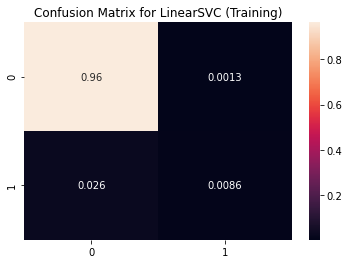

In [111]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(full_pipeline, X_train, y_train, cv=5)

plt.figure()
sns.heatmap(confusion_matrix(y_train, y_train_pred)/y_train.shape[0], annot=True, annot_kws={'size':10})
plt.title('Confusion Matrix for LinearSVC (Training)')

In [113]:
from sklearn.metrics import precision_score, recall_score
print('Training Recall Score: ', recall_score(y_train, y_train_pred))
print('Training Precision Score: ', precision_score(y_train, y_train_pred))
print('Validation Recall Score: ', recall_score(y_valid, y_valid_pred))
print('Validation Precision Score: ', precision_score(y_valid, y_valid_pred))

Training Recall Score:  0.24820143884892087
Training Precision Score:  0.8734177215189873
Validation Recall Score:  0.32786885245901637
Validation Precision Score:  0.8
